In [ ]:
import sys
print(sys.version)

3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]


# Data Loading

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional

In [ ]:
data = pd.read_csv("Wind Speed Data 2019-2024 Hourly.csv", sep = ";")

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   YEAR    8784 non-null   int64  
 1   MO      8784 non-null   int64  
 2   DY      8784 non-null   int64  
 3   HR      8784 non-null   int64  
 4   WS50M   8784 non-null   float64
 5   DATE    8784 non-null   object 
dtypes: float64(1), int64(4), object(1)
memory usage: 411.9+ KB


In [ ]:
data.head()

,YEAR,MO,DY,HR,WS50M,DATE
0,2024,1,1,0,3.44,01/01/2024
1,2024,1,1,1,3.00,01/01/2024
2,2024,1,1,2,2.50,01/01/2024
3,2024,1,1,3,1.92,01/01/2024
4,2024,1,1,4,1.25,01/01/2024


In [ ]:
data['DATE']=pd.to_datetime(data['DATE'], dayfirst=True)
print(data['DATE'].dtypes)

datetime64[ns]


In [ ]:
data = data.set_index('DATE')

In [ ]:
data['timestamp_numeric'] = range(len(data))

In [ ]:
wind_speed = data[['WS50M']].dropna()

(np.float64(19723.0), np.float64(20088.0))

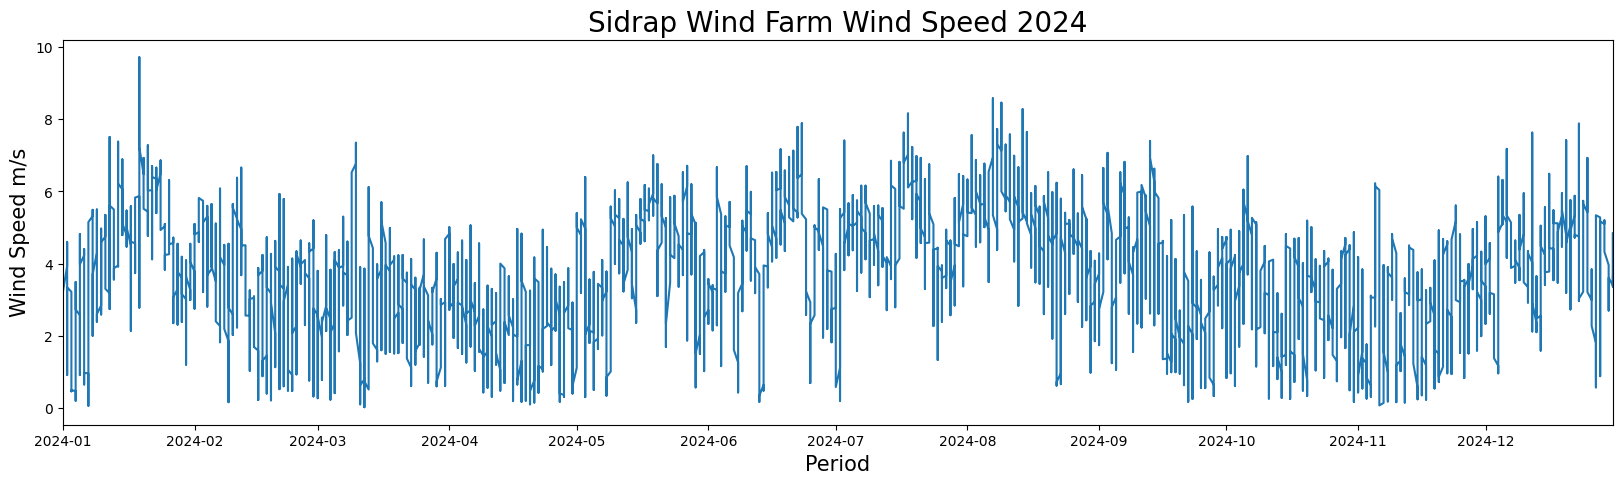

In [ ]:
fig = plt.subplots(figsize=(20, 5))
plt.plot(data.index, wind_speed)
plt.title('Sidrap Wind Farm Wind Speed 2024', fontsize=20)
plt.xlabel('Period', fontsize=15)
plt.ylabel('Wind Speed m/s', fontsize=15)
plt.xlim(pd.Timestamp('2024-1-1'), pd.Timestamp('2024-12-31'))

# Data Preprocessing

In [ ]:
scaler = MinMaxScaler()
wind_speed_scaled = scaler.fit_transform(wind_speed)

In [ ]:
def create_dataset(dataset, time_step=24):
    X, y = [], []
    for i in range(len(dataset) - time_step):
        X.append(dataset[i:(i + time_step), 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 24
X, y = create_dataset(wind_speed_scaled, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

In [ ]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Model Training

In [ ]:
model = Sequential()
model.add(Bidirectional(LSTM(128, activation='relu', return_sequences=True), input_shape=(X.shape[1], X.shape[2])))
model.add(Bidirectional(LSTM(64, activation='relu', return_sequences=True)))
model.add(Bidirectional(LSTM(32, activation='relu', return_sequences=False)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 24, 256)        │       133,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 24, 128)        │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 338,753 (1.29 MB)

 Trainable params: 338,753 (1.29 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 33s 110ms/step - loss: 0.0320
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 41s 109ms/step - loss: 0.0031
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 41s 109ms/step - loss: 0.0019
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 41s 110ms/step - loss: 0.0013
Epoch 5/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 23s 105ms/step - loss: 0.0010
Epoch 6/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 24s 108ms/step - loss: 9.3848e-04
Epoch 7/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 41s 110ms/step - loss: 9.6296e-04
Epoch 8/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 24s 109ms/step - loss: 9.4462e-04
Epoch 9/100
197/219 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - loss: 8.3882e-04

KeyboardInterrupt: 

# Model Evaluation

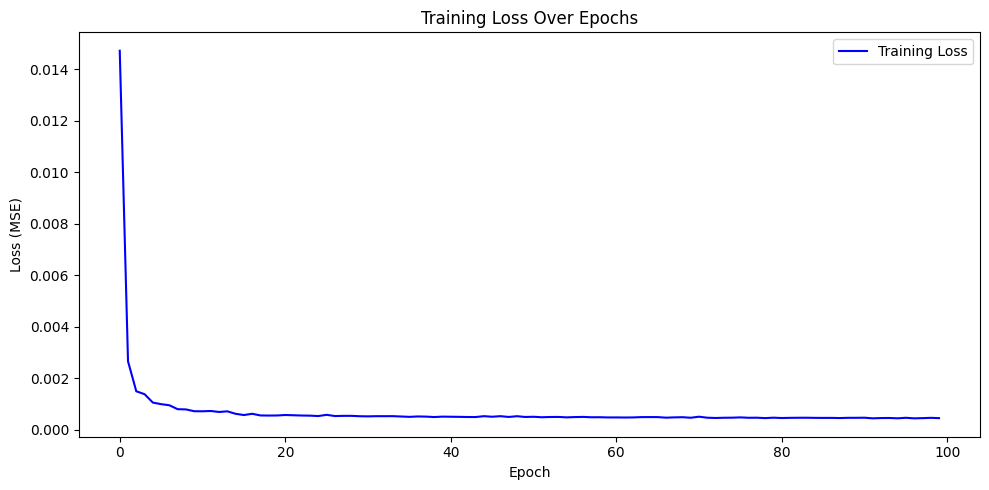

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
pred_scaled = model.predict(X_test)
pred_original = scaler.inverse_transform(pred_scaled)
y_true_original = scaler.inverse_transform(y_test.reshape(-1, 1))

plot_range = range(len(pred_original))

55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step


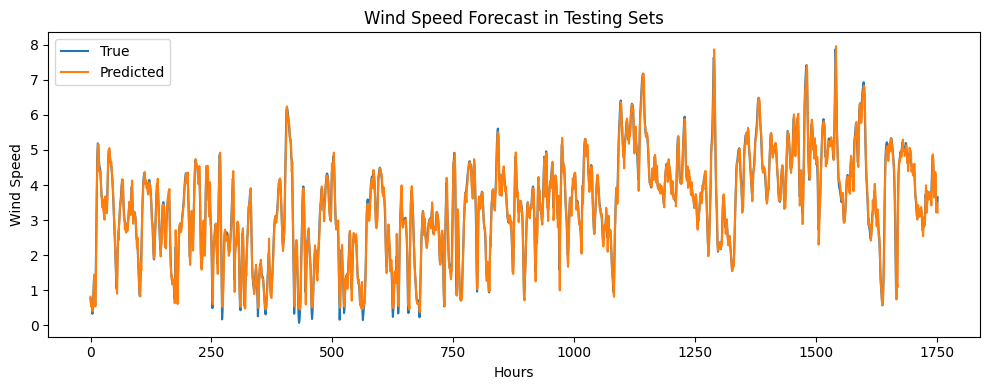

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(plot_range, y_true_original, label='True')
plt.plot(plot_range, pred_original, label='Predicted')
plt.xlabel('Hours')
plt.ylabel('Wind Speed')
plt.title('Wind Speed Forecast in Testing Sets')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
mae = mean_absolute_error(y_true_original, pred_original)
mse = mean_squared_error(y_true_original, pred_original)
mape = mean_absolute_percentage_error(y_true_original, pred_original)
rmse = np.sqrt(mse)
r2 = r2_score(y_true_original, pred_original)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Squared Error (MSE): 0.0392
Root Mean Squared Error (RMSE): 0.1981
Mean Absolute Error (MAE): 0.1435
Mean Absolute Percentage Error (MAPE): 0.0712
R² Score: 0.9805


# Testing Schemes

In [ ]:
hours_list = [24, 48, 72]

for hours in hours_list:
    pred_last = pred_original[:hours]
    true_last = y_true_original[:hours]

    mse = mean_squared_error(true_last, pred_last)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(true_last, pred_last)
    mape = mean_absolute_percentage_error(true_last, pred_last)
    r2 = r2_score(true_last, pred_last)

    print(f"Metrics for last {hours} hours:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}")
    print(f"R² Score: {r2:.4f}")
    print()

    plt.figure(figsize=(10, 4))
    plt.plot(true_last, label='True')
    plt.plot(pred_last, label='Predicted')
    plt.title(f'Wind Speed Forecast for {hours} Hours')
    plt.xlabel('Hours')
    plt.ylabel('Wind Speed')
    plt.legend()
    plt.show()

NameError: name 'pred_original' is not defined

In [ ]:
def generate_forecast_sequences(test_data, lookback, forecast_horizon):
    X, y_indices = [], []
    for i in range(len(test_data) - lookback - forecast_horizon + 1):
        X.append(test_data[i:i+lookback])
        y_indices.append(i + lookback + forecast_horizon - 1)  # index of target
    return np.array(X), np.array(y_indices)

# Normalize your test data (already fitted with training scaler)
test_scaled = scaler.transform(test_data.reshape(-1, 1))  # shape: (1750, 1)

forecast_horizons = [24, 48, 72]
predictions = {}

for horizon in forecast_horizons:
    X_test, y_indices = generate_forecast_sequences(test_scaled, lookback=72, forecast_horizon=horizon)
    y_pred_scaled = model.predict(X_test)  # load the corresponding trained model for each horizon
    y_pred = scaler.inverse_transform(y_pred_scaled)
    predictions[horizon] = {
        'inputs': X_test,
        'predictions': y_pred.flatten(),
        'target_indices': y_indices
    }